# Classification Model Build (QSARtuna)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split

tob_data = pd.read_csv('tob_processed.csv', sep=',')
tob_data = tob_data.drop(columns=['Unnamed: 0'])

col_data = pd.read_csv('col_processed.csv', sep=',')
col_data = col_data.drop(columns=['Unnamed: 0'])

tob_y = tob_data['Class'].values

In [16]:
tob_data = tob_data.drop(columns=['ID','Tob_Pot_1','RB','clogP','tPSA','Hacc','Hdon','LogSw','Mol Weight','MCS Cluster'])
# data containing only SMILES strings and the active/inactive class (1 or 0)

In [2]:
# -------------------------------------------------------------------------------------

# import rdkit
# from rdkit import Chem
# from rdkit.Chem import rdMolDescriptors

# def smiles_to_fingerprint(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     # Generate Morgan fingerprint with radius 2 and 1024 bits
#     return np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

# # --------------------------------------------------------------------------------------

# # generate fingerprints 

# tob_data['Fingerprint'] = tob_data['Structure'].apply(smiles_to_fingerprint)
# fingerprints = np.array(tob_data['Fingerprint'].tolist())
# fingerprint_df = pd.DataFrame(fingerprints, columns=[f'FP {i+1}' for i in range(len(tob_data['Fingerprint'][0]))])
# # combine descriptors into one vector

# descriptors = tob_data[['Mol Weight','RB','clogP','tPSA','Hacc','Hdon','LogSw']].values

# # combine fingerprint and descriptors into one vector

# vector = np.hstack([fingerprints, descriptors])

# # target variable: Class

# tob_y = tob_data['Class'].values


In [9]:
# desc_df = pd.DataFrame(descriptors, columns=['MWt','RB','clogP','TPSA','Hacc','Hdon','LogSw'])

# main = pd.concat([fingerprint_df, desc_df], axis=1)
# main.to_csv('./TOB_full_vector.csv')

# tob_class_main = pd.DataFrame(tob_y, columns=['Class'])
# tob_class_main.to_csv('./TOB_full_class.csv')

In [23]:
tob_train, tob_test = train_test_split(tob_data, test_size=0.3)

tob_train.to_csv('./tobramycin_train_full.csv')
tob_test.to_csv('./tobramycin_test_full.csv')

In [16]:
import sys
sys.path.append('..')

import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)

from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    KNeighborsClassifier,
    RandomForestClassifier,
    SVC,
    LogisticRegression,
    PRFClassifier,
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

# Calibrated (undersampled) (from QSARtuna tutorial example using calibration)

In [1]:
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import CalibratedClassifierCVWithVA, RandomForestClassifier
from optunaz.config.optconfig import OptimizationConfig
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

from sklearn.calibration import calibration_curve
import seaborn as sns

from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

undersamp_cal_config = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
            ),
            n_folds=5,
            ensemble="True",
            method="sigmoid", 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [ ]:
tob_cal_study = optimize(undersamp_cal_config, study_name="tob_calibrated_rf")

In [3]:
build_best(buildconfig_best(tob_cal_study), "./tob_cal_classifier.pkl")

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file=None, save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=76, best_value=0.6653424308425429, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)

In [13]:
import pickle

with open("M:/ML_scripts/notebooks/tob_cal_classifier.pkl", "rb") as f:
    tob_undersamp_cal_model = pickle.load(f)

In [14]:
tob_undersamp_cal_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.6793703])

# Uncalibrated (undersampled)

In [6]:
tob_uncal_config = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [ ]:
tob_uncal_study = optimize(tob_uncal_config, study_name='tob_uncalibrated_rf')

In [8]:
build_best(buildconfig_best(tob_uncal_study), './tob_uncal_classifier.pkl')

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file=None, save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=55, best_value=0.6802447883790815, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)

In [15]:
with open('M:/ML_scripts/notebooks/tob_uncal_classifier.pkl', 'rb') as d:
    tob_undersamp_uncal_model = pickle.load(d)

In [16]:
tob_undersamp_uncal_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.88356812])

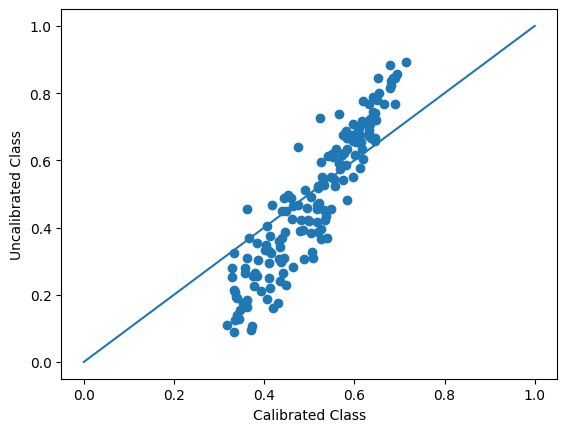

In [17]:
df = pd.read_csv('./tobramycin_undersampled_test.csv')
expected = df[undersamp_cal_config.data.response_column]
input_column = df[undersamp_cal_config.data.input_column]
calibrated_predicted = tob_undersamp_cal_model.predict_from_smiles(input_column)
uncalibrated_predicted = tob_undersamp_uncal_model.predict_from_smiles(input_column)

# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
ax = plt.scatter(calibrated_predicted, uncalibrated_predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Calibrated {undersamp_cal_config.data.response_column}");
plt.ylabel(f"Uncalibrated {undersamp_cal_config.data.response_column}");

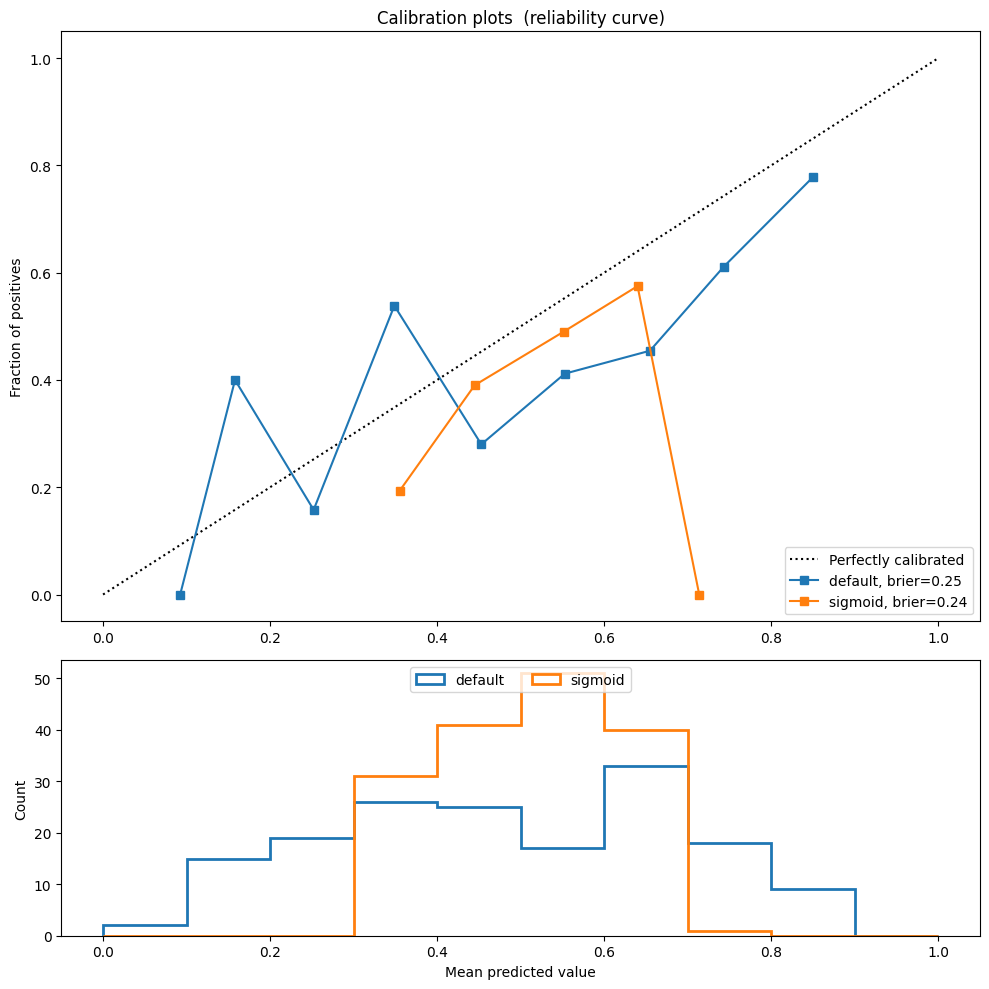

In [18]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for pred, name in [(uncalibrated_predicted, 'default'),
                  (calibrated_predicted, 'sigmoid')]:

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(expected, pred, n_bins=10)
    
    brier=brier_score_loss(expected,pred)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s, brier=%.2f" % (name, brier))

    ax2.hist(pred, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Predicted Class')

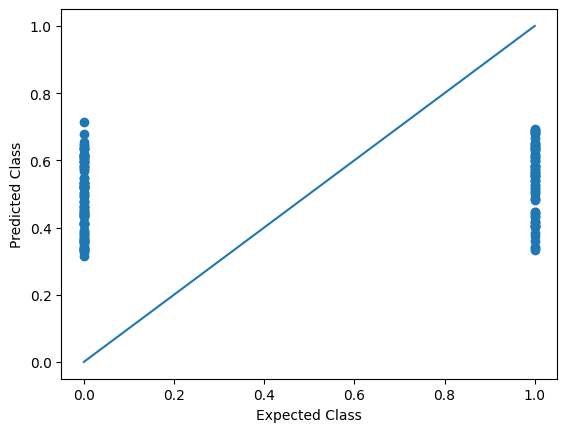

In [20]:
df1 = pd.read_csv('M:/ML_scripts/notebooks/tobramycin_undersampled_test.csv')  # Load test data.

expected1 = df1[undersamp_cal_config.data.response_column]
predicted1 = tob_undersamp_cal_model.predict_from_smiles(df1[undersamp_cal_config.data.input_column])

ax = plt.scatter(expected1, predicted1)
lims = [expected1.min(), expected1.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {undersamp_cal_config.data.response_column}")
plt.ylabel(f"Predicted {undersamp_cal_config.data.response_column}")

# Calibrated (oversampled)

In [21]:
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import CalibratedClassifierCVWithVA, RandomForestClassifier
from optunaz.config.optconfig import OptimizationConfig
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

from sklearn.calibration import calibration_curve
import seaborn as sns

from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

oversamp_cal_config = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
            ),
            n_folds=5,
            ensemble="True",
            method="sigmoid", 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [ ]:
tob_cal_study1 = optimize(oversamp_cal_config, study_name="tob_oversamp_calibrated_rf")

In [24]:
build_best(buildconfig_best(tob_cal_study1), "./tob_oversamp_cal_classifier.pkl")

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file=None, save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=48, best_value=0.7262495029152507, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False))

In [27]:
with open('M:/ML_scripts/notebooks/tob_oversamp_cal_classifier.pkl', 'rb') as b:
    tob_oversamp_cal_model = pickle.load(b)

In [34]:
tob_oversamp_cal_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.30842265])

# Uncalibrated (oversampled)

In [29]:
oversamp_uncal_config = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [ ]:
tob_uncal_study1 = optimize(oversamp_uncal_config, study_name="tob_oversamp_uncalibrated_rf")

In [31]:
build_best(buildconfig_best(tob_uncal_study1), "./tob_oversamp_uncal_classifier.pkl")

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file=None, save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=94, best_value=0.7165638670144352, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False))

In [32]:
with open('M:/ML_scripts/notebooks/tob_oversamp_uncal_classifier.pkl', 'rb') as p:
    tob_oversamp_uncal_model = pickle.load(p)

In [33]:
tob_oversamp_uncal_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.79087858])

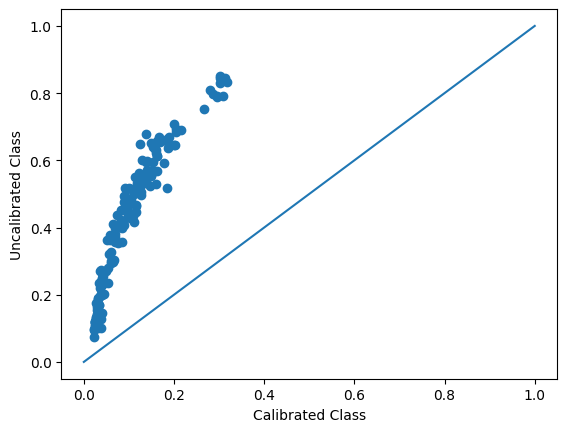

In [35]:
df2 = pd.read_csv('./tobramycin_oversampled_test.csv')
expected2 = df[oversamp_cal_config.data.response_column]
input_column2 = df[oversamp_cal_config.data.input_column]
calibrated_predicted2 = tob_oversamp_cal_model.predict_from_smiles(input_column)
uncalibrated_predicted2 = tob_oversamp_uncal_model.predict_from_smiles(input_column)

# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
ax = plt.scatter(calibrated_predicted2, uncalibrated_predicted2)
lims = [expected2.min(), expected2.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Calibrated {oversamp_cal_config.data.response_column}");
plt.ylabel(f"Uncalibrated {oversamp_cal_config.data.response_column}");

In [ ]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for pred, name in [(uncalibrated_predicted2, 'default'),
                  (calibrated_predicted2, 'sigmoid')]:

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(expected2, pred, n_bins=10)
    
    brier=brier_score_loss(expected2,pred)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s, brier=%.2f" % (name, brier))

    ax2.hist(pred, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Predicted Class')

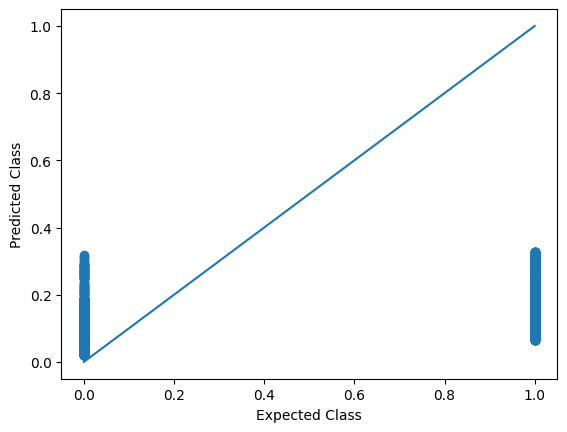

In [38]:
df3 = pd.read_csv('M:/ML_scripts/notebooks/tobramycin_oversampled_test.csv')  # Load test data.

expected3 = df3[oversamp_cal_config.data.response_column]
predicted3 = tob_oversamp_cal_model.predict_from_smiles(df3[oversamp_cal_config.data.input_column])

ax = plt.scatter(expected3, predicted3)
lims = [expected3.min(), expected3.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {oversamp_cal_config.data.response_column}")
plt.ylabel(f"Predicted {oversamp_cal_config.data.response_column}")

In [50]:
print(tob_undersamp_uncal_model)

QSARtunaModel(predictor=CalibratedClassifierCVWithVA(estimator=RandomForestClassifier(class_weight='balanced',
                                                              max_depth=7,
                                                              max_features=1.0,
                                                              n_estimators=88,
                                                              n_jobs=-1,
                                                              random_state=42),
                             n_folds=5), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)), mode=<ModelMode.CLASSIFICATION: 'classification'>, transform=None, aux_transform=None, metadata={'name': '', 'buildconfig': {'data': {'training_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', 'input_column': 'Structure', 'response_column': 'Class', 'response_type': 'classification', 'deduplication_strategy': {'name': 'KeepMedian'}, '

# Regular QSARtuna optimisation

In [94]:
from optunaz.config.optconfig import KNeighborsClassifier, LogisticRegression, ChemPropClassifier

config = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv",
        test_dataset_file="M:/ML_scripts/notebooks/tobramycin_undersampled_test.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
        ), KNeighborsClassifier.new(), LogisticRegression.new(), ChemPropClassifier.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [95]:
study = optimize(config, study_name='run1')

[I 2025-01-16 12:11:20,995] A new study created in memory with name: run1
[I 2025-01-16 12:11:21,040] A new study created in memory with name: study_name_0
[I 2025-01-16 12:11:22,541] Trial 0 finished with value: 0.6465952800543215 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: 0.6465952800543215.
[I 2025-01-16 12:11:23,150] Trial 1 finished with value: 0.6326620314734288 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 10, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5663154155350739]


[I 2025-01-16 12:11:26,935] Trial 7 finished with value: 0.5407329684953791 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 2, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 3 with value: 0.6594508833936381.
[I 2025-01-16 12:11:27,453] Trial 8 finished with value: 0.556198274332163 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 3, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'd

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5504615683802662]


[I 2025-01-16 12:11:28,161] Trial 11 finished with value: 0.6022605403260524 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 12, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 76, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 3 with value: 0.6594508833936381.
[I 2025-01-16 12:11:28,382] Trial 12 finished with value: 0.6397594928697388 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 3 with value: 0.6594508833936381.
[I 2025-01-16 12:11:28,388] Tr

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6465952800543215]


[I 2025-01-16 12:11:28,726] Trial 14 finished with value: 0.6670249135127893 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 24, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:29,054] Trial 15 finished with value: 0.6023698968393871 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 29, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 59, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6397594928697388]


[I 2025-01-16 12:11:29,536] Trial 17 finished with value: 0.512960361594594 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:29,845] Trial 18 finished with value: 0.6152854102054451 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 35, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": 

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'saga', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [0.4973096645831836]


[I 2025-01-16 12:11:32,702] Trial 27 finished with value: 0.5596798859694294 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:32,954] Trial 28 finished with value: 0.5773975086214922 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 9, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name"

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5504615683802662]


[I 2025-01-16 12:11:33,675] Trial 31 finished with value: 0.6607281133976857 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 45, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:33,685] Trial 32 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [0.512960361594594]


[I 2025-01-16 12:11:33,924] Trial 33 finished with value: 0.4937040691599487 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'newton-cg', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:33,934] Trial 34 pruned. Duplicate parameter set
[I 2025-01-16 12:11:33,944] Trial 35 pruned. Duplicate parameter set
[I 2025-01-16 12:11:33,954] Trial 36 pruned. Duplicate parameter set
[I 2025-01-16 12:11:33,963] Trial 37 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6465952800543215]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5504615683802662]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KN

[I 2025-01-16 12:11:34,372] Trial 38 finished with value: 0.6414880741469204 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'sag', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 2025-01-16 12:11:34,715] Trial 39 finished with value: 0.5087808952355071 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 14, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 25, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 14 with value: 0.6670249135127893.
[I 202

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 6, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 20, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6544957865207367]


[I 2025-01-16 12:11:39,739] Trial 55 finished with value: 0.658077597678162 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 6, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 42, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 52 with value: 0.6739880025512673.
[I 2025-01-16 12:11:40,053] Trial 56 finished with value: 0.6738241342840838 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 9, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 20, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 7, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 23, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6733896554270584]


[I 2025-01-16 12:11:42,793] Trial 64 finished with value: 0.666148133324753 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 100, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 61 with value: 0.681029655104861.
[I 2025-01-16 12:11:43,370] Trial 65 finished with value: 0.667859611918311 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 92, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", 

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6397594928697388]


[I 2025-01-16 12:11:54,023] Trial 89 finished with value: 0.6746597972036243 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 18, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 61 with value: 0.681029655104861.
[I 2025-01-16 12:11:54,285] Trial 90 finished with value: 0.6071396283423518 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 13, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 19, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 13, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 18, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6743357736162032]


[I 2025-01-16 12:11:55,329] Trial 94 finished with value: 0.6595718292881894 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 30, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 61 with value: 0.681029655104861.
[I 2025-01-16 12:11:55,702] Trial 95 finished with value: 0.6741689603054075 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 12, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 22, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP",

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 9, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 13, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6674103921040592]


In [96]:
build_best(buildconfig_best(study), "./tob_undersamp_classifier_run1.pkl")

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file='M:/ML_scripts/notebooks/tobramycin_undersampled_test.csv', save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=61, best_value=0.681029655104861, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECF

In [97]:
with open('M:/ML_scripts/notebooks/tob_undersamp_classifier_run1.pkl', 'rb') as a:
    run1_model = pickle.load(a)

run1_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.89112007])

In [98]:
print(run1_model)

QSARtunaModel(predictor=RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=1.0,
                       n_estimators=19, n_jobs=-1, random_state=42), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)), mode=<ModelMode.CLASSIFICATION: 'classification'>, transform=None, aux_transform=None, metadata={'name': '', 'buildconfig': {'data': {'training_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv', 'input_column': 'Structure', 'response_column': 'Class', 'response_type': 'classification', 'deduplication_strategy': {'name': 'KeepMedian'}, 'split_strategy': {'name': 'NoSplitting'}, 'test_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_undersampled_test.csv', 'save_intermediate_files': False, 'log_transform': False, 'log_transform_base': None, 'log_transform_negative': None, 'log_transform_unit_conversion': None, 'probabilistic_threshold_representation': False, 'probabilistic_threshold_representati

In [99]:
build_merged(buildconfig_best(study), "./tob_undersamp_merged_classifier.pkl")

In [100]:
with open('M:/ML_scripts/notebooks/tob_undersamp_merged_classifier.pkl', 'rb') as g:
    merged_model = pickle.load(g)

merged_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.88396009])

In [102]:
print(merged_model)

QSARtunaModel(predictor=RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=1.0,
                       n_estimators=19, n_jobs=-1, random_state=42), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)), mode=<ModelMode.CLASSIFICATION: 'classification'>, transform=None, aux_transform=None, metadata={'name': '', 'buildconfig': {'data': {'training_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_undersampled_train.csv', 'input_column': 'Structure', 'response_column': 'Class', 'response_type': 'classification', 'deduplication_strategy': {'name': 'KeepMedian'}, 'split_strategy': {'name': 'NoSplitting'}, 'test_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_undersampled_test.csv', 'save_intermediate_files': False, 'log_transform': False, 'log_transform_base': None, 'log_transform_negative': None, 'log_transform_unit_conversion': None, 'probabilistic_threshold_representation': False, 'probabilistic_threshold_representati

In [103]:
from optunaz.config.optconfig import KNeighborsClassifier, LogisticRegression, ChemPropClassifier

config1 = OptimizationConfig(
    data=Dataset(
        input_column="Structure",
        response_column="Class",
        training_dataset_file="M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv",
        test_dataset_file="M:/ML_scripts/notebooks/tobramycin_oversampled_test.csv"),
    descriptors=[ECFP.new(), MACCS_keys.new(), PathFP.new()],
    algorithms=[RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=10, high=100
                )
        ), KNeighborsClassifier.new(), LogisticRegression.new(), ChemPropClassifier.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=5,
        n_trials=100,
        n_startup_trials=40,
        n_jobs=-1,
        direction=OptimizationDirection.MAXIMIZATION,
        random_seed=42,
    ),
)

In [104]:
study1 = optimize(config1, study_name='oversamp_run1')

[I 2025-01-16 12:16:03,995] A new study created in memory with name: oversamp_run1
[I 2025-01-16 12:16:04,042] A new study created in memory with name: study_name_0
[I 2025-01-16 12:16:20,422] Trial 0 finished with value: 0.6412529184389136 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 0 with value: 0.6412529184389136.
[I 2025-01-16 12:16:28,689] Trial 1 finished with value: 0.6842151753858896 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327fa

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 10, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.6199135265928543]


[I 2025-01-16 12:17:16,086] Trial 7 finished with value: 0.5291330261627925 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 2, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 3 with value: 0.6906859043696684.
[I 2025-01-16 12:17:24,646] Trial 8 finished with value: 0.5292046238974996 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 3, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, '

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5617674970518699]


[I 2025-01-16 12:17:33,602] Trial 11 finished with value: 0.6527241511590733 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 12, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 76, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 3 with value: 0.6906859043696684.
[I 2025-01-16 12:17:39,002] Trial 12 finished with value: 0.6600372142363137 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 3 with value: 0.6906859043696684.
[I 2025-01-16 12:17:39,022] Tr

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6412529184389136]


[I 2025-01-16 12:17:46,349] Trial 14 finished with value: 0.7051697511135867 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 24, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 14 with value: 0.7051697511135867.
[I 2025-01-16 12:17:50,494] Trial 15 finished with value: 0.6414512513433815 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 29, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 59, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6600372142363137]


[I 2025-01-16 12:17:59,104] Trial 17 finished with value: 0.49395265769547747 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 14 with value: 0.7051697511135867.
[I 2025-01-16 12:18:03,138] Trial 18 finished with value: 0.6495899872614465 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 35, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name"

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'saga', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [0.5587774204162539]


[I 2025-01-16 12:18:57,344] Trial 27 finished with value: 0.5903414116007133 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 14 with value: 0.7051697511135867.
[I 2025-01-16 12:19:02,230] Trial 28 finished with value: 0.6026277692953569 and parameters: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 9, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name"

Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5617674970518699]


[I 2025-01-16 12:19:16,541] Trial 31 finished with value: 0.7136837361911675 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 45, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 2025-01-16 12:19:16,565] Trial 32 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [0.49395265769547747]


[I 2025-01-16 12:19:22,956] Trial 33 finished with value: 0.5596953535688842 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'newton-cg', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 2025-01-16 12:19:22,981] Trial 34 pruned. Duplicate parameter set
[I 2025-01-16 12:19:23,002] Trial 35 pruned. Duplicate parameter set
[I 2025-01-16 12:19:23,025] Trial 36 pruned. Duplicate parameter set
[I 2025-01-16 12:19:23,049] Trial 37 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 6, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6412529184389136]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KNeighborsClassifier_algorithm_hash': 'e51ca55089f389fc37a736adb2aa0e42', 'metric__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__e51ca55089f389fc37a736adb2aa0e42': 4, 'weights__e51ca55089f389fc37a736adb2aa0e42': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [0.5617674970518699]
Duplicated trial: {'algorithm_name': 'KNeighborsClassifier', 'KN

[I 2025-01-16 12:19:29,790] Trial 38 finished with value: 0.6490178325693898 and parameters: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'sag', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 2025-01-16 12:19:35,414] Trial 39 finished with value: 0.5931902171017767 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 14, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 25, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 202

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 9, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 42, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7107671634198206]


[I 2025-01-16 12:20:31,421] Trial 48 finished with value: 0.7125950971644137 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 14, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 46, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 2025-01-16 12:20:42,144] Trial 49 finished with value: 0.7094120038119371 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 17, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 45, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP"

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 13, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 55, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7120766066746267]
Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 13, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 54, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7112183752260999]


[I 2025-01-16 12:22:10,154] Trial 59 finished with value: 0.7088418612933717 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 15, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 34, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 31 with value: 0.7136837361911675.
[I 2025-01-16 12:22:23,621] Trial 60 finished with value: 0.7150631198895783 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 70, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP"

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 71, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7149634864019461]


[I 2025-01-16 12:25:13,552] Trial 73 finished with value: 0.7138512001341598 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 6, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 86, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 66 with value: 0.7151066507802135.
[I 2025-01-16 12:25:22,300] Trial 74 finished with value: 0.6828631056208145 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 2, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 69, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", 

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 10, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 80, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7129421428958456]
Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 11, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 82, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7147578680761906]


[I 2025-01-16 12:26:09,546] Trial 79 finished with value: 0.7151131609712501 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 65, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 79 with value: 0.7151131609712501.
[I 2025-01-16 12:26:22,665] Trial 80 finished with value: 0.7160343017901329 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 63, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", 

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 63, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7160343017901329]


[I 2025-01-16 12:27:02,260] Trial 84 finished with value: 0.7151326566659831 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 67, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 80 with value: 0.7160343017901329.
[I 2025-01-16 12:27:15,444] Trial 85 finished with value: 0.7160439814843409 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 61, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", 

Duplicated trial: {'algorithm_name': 'LogisticRegression', 'LogisticRegression_algorithm_hash': '8908f22fafa8a855aeb58e3dc9f9ce8e', 'solver__8908f22fafa8a855aeb58e3dc9f9ce8e': 'lbfgs', 'C__8908f22fafa8a855aeb58e3dc9f9ce8e': 1.0, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.6600372142363137]


[I 2025-01-16 12:27:53,156] Trial 89 finished with value: 0.715859017305154 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 7, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 60, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 85 with value: 0.7160439814843409.
[I 2025-01-16 12:27:58,941] Trial 90 finished with value: 0.6540025457959758 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 7, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 59, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_ke

Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 60, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7158313770608856]
Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 8, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 67, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7151326566659831]


[I 2025-01-16 12:28:11,709] Trial 94 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 7, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 63, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [0.7160025910071232]


[I 2025-01-16 12:28:23,020] Trial 95 finished with value: 0.7133090144492675 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 9, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 61, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 85 with value: 0.7160439814843409.
[I 2025-01-16 12:28:33,621] Trial 96 finished with value: 0.7133312401859241 and parameters: {'algorithm_name': 'RandomForestClassifier', 'RandomForestClassifier_algorithm_hash': '81728f5b173c58aa046e6327faa7c4b5', 'max_depth__81728f5b173c58aa046e6327faa7c4b5': 6, 'n_estimators__81728f5b173c58aa046e6327faa7c4b5': 66, 'max_features__81728f5b173c58aa046e6327faa7c4b5': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", 

In [105]:
build_best(buildconfig_best(study1), "./tob_oversamp_classifier_run1.pkl")

BuildConfig(data=Dataset(training_dataset_file='M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', input_column='Structure', response_column='Class', response_type='classification', aux_column=None, aux_transform=None, deduplication_strategy=KeepMedian(name='KeepMedian'), split_strategy=NoSplitting(name='NoSplitting'), test_dataset_file='M:/ML_scripts/notebooks/tobramycin_oversampled_test.csv', save_intermediate_files=False, intermediate_training_dataset_file=None, intermediate_test_dataset_file=None, log_transform=False, log_transform_base=None, log_transform_negative=None, log_transform_unit_conversion=None, probabilistic_threshold_representation=False, probabilistic_threshold_representation_threshold=None, probabilistic_threshold_representation_std=None, _sets_initialized=True), metadata=BuildConfig.Metadata(name='', cross_validation=5, shuffle=False, best_trial=85, best_value=0.7160439814843409, n_trials=100, visualization=None), descriptor=ECFP(name='ECFP', parameters=ECFP

In [106]:
with open('M:/ML_scripts/notebooks/tob_oversamp_classifier_run1.pkl', 'rb') as h:
    oversamp_model = pickle.load(h)

oversamp_model.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.82892423])

In [107]:
print(oversamp_model)

QSARtunaModel(predictor=RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=1.0,
                       n_estimators=61, n_jobs=-1, random_state=42), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)), mode=<ModelMode.CLASSIFICATION: 'classification'>, transform=None, aux_transform=None, metadata={'name': '', 'buildconfig': {'data': {'training_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', 'input_column': 'Structure', 'response_column': 'Class', 'response_type': 'classification', 'deduplication_strategy': {'name': 'KeepMedian'}, 'split_strategy': {'name': 'NoSplitting'}, 'test_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_oversampled_test.csv', 'save_intermediate_files': False, 'log_transform': False, 'log_transform_base': None, 'log_transform_negative': None, 'log_transform_unit_conversion': None, 'probabilistic_threshold_representation': False, 'probabilistic_threshold_representation

In [81]:
build_merged(buildconfig_best(study1), "./tob_oversamp_merged_classifier.pkl")

In [90]:
with open('M:/ML_scripts/notebooks/tob_oversamp_merged_classifier.pkl', 'rb') as h:
    oversamp_model1 = pickle.load(h)

oversamp_model1.predict_from_smiles('Cc1cc(c(o1)C)C(=O)[N@]2CCCCNC(=O)[C@@H]3C[C@@H](C[N@]3C(=O)Cc4c[n@](c5c4cccc5)C)[N@@](CCC2)C(=O)c6ccccc6')

array([0.88555372])

In [91]:
print(oversamp_model1)

QSARtunaModel(predictor=RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=1.0,
                       n_estimators=61, n_jobs=-1, random_state=42), descriptor=ECFP(name='ECFP', parameters=ECFP.Parameters(radius=3, nBits=2048, returnRdkit=False)), mode=<ModelMode.CLASSIFICATION: 'classification'>, transform=None, aux_transform=None, metadata={'name': '', 'buildconfig': {'data': {'training_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_oversampled_train.csv', 'input_column': 'Structure', 'response_column': 'Class', 'response_type': 'classification', 'deduplication_strategy': {'name': 'KeepMedian'}, 'split_strategy': {'name': 'NoSplitting'}, 'test_dataset_file': 'M:/ML_scripts/notebooks/tobramycin_oversampled_test.csv', 'save_intermediate_files': False, 'log_transform': False, 'log_transform_base': None, 'log_transform_negative': None, 'log_transform_unit_conversion': None, 'probabilistic_threshold_representation': False, 'probabilistic_threshold_representation